# FDA Food Adverse Events - Data Preprocessing

This notebook handles data cleaning, transformation, and feature engineering to prepare the dataset for anomaly detection.

**Goals**:
1. Clean and standardize the data
2. Handle missing values appropriately
3. Create time series aggregations by reaction type
4. Engineer features for anomaly detection
5. Prepare train/test splits for modeling

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
# Import custom modules
import sys
sys.path.append('../src')
from data_loader import FDADataLoader

## 1. Load Data

Load the full dataset (or a large sample) for preprocessing.

In [3]:
# Load data
data_path = '../data/raw/food-event-0001-of-0001.json'
loader = FDADataLoader(data_path)

# Adjust max_records based on your memory constraints
# Use None to load all data
print("Loading data...")
df = loader.load_to_dataframe(max_records=100000)  # Adjust as needed
print(f"Loaded {len(df):,} records")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

INFO:data_loader:Loading FDA data to DataFrame...


Loading data...


INFO:data_loader:Processed 10000 records...
INFO:data_loader:Processed 20000 records...
INFO:data_loader:Processed 30000 records...
INFO:data_loader:Processed 40000 records...
INFO:data_loader:Processed 50000 records...
INFO:data_loader:Processed 60000 records...
INFO:data_loader:Processed 70000 records...
INFO:data_loader:Processed 80000 records...
INFO:data_loader:Processed 90000 records...
INFO:data_loader:Loaded 92800 records into DataFrame


Loaded 92,800 records
Memory usage: 77.11 MB


## 2. Data Cleaning

In [4]:
# Remove duplicate report numbers
print(f"Records before deduplication: {len(df):,}")
df = df.drop_duplicates(subset=['report_number'], keep='first')
print(f"Records after deduplication: {len(df):,}")

Records before deduplication: 92,800
Records after deduplication: 92,800


In [5]:
# Clean date column
df['date_started'] = pd.to_datetime(df['date_started'], errors='coerce')

# Remove records with missing dates (critical for time series)
print(f"Records before removing null dates: {len(df):,}")
df = df.dropna(subset=['date_started'])
print(f"Records after removing null dates: {len(df):,}")

Records before removing null dates: 92,800
Records after removing null dates: 57,264


In [6]:
# Remove outlier dates (future dates or very old dates)
current_date = pd.Timestamp.now()
min_date = pd.Timestamp('2000-01-01')  # Reasonable cutoff

print(f"Date range before filtering: {df['date_started'].min()} to {df['date_started'].max()}")
df = df[(df['date_started'] >= min_date) & (df['date_started'] <= current_date)]
print(f"Date range after filtering: {df['date_started'].min()} to {df['date_started'].max()}")
print(f"Records after date filtering: {len(df):,}")

Date range before filtering: 1925-01-23 00:00:00 to 2025-04-01 00:00:00
Date range after filtering: 2000-01-01 00:00:00 to 2025-04-01 00:00:00
Records after date filtering: 57,188


In [7]:
# Clean age data
# Remove unrealistic ages

# First, convert to numeric (coerce errors to NaN)
df['consumer_age'] = pd.to_numeric(df['consumer_age'], errors='coerce')

# Now remove unrealistic ages
df.loc[(df['consumer_age'] < 0) | (df['consumer_age'] > 120), 'consumer_age'] = np.nan

print(f"Age range after cleaning: {df['consumer_age'].min():.1f} to {df['consumer_age'].max():.1f}")
print(f"Records with valid age: {df['consumer_age'].notna().sum():,}")

Age range after cleaning: 1.0 to 118.0
Records with valid age: 39,973


In [8]:
# Standardize reactions (ensure all are lists)
def standardize_reactions(reactions):
    """
    Standardize reactions to lowercase.
    Handles lists, strings, None, and NaN values.
    """
    # None/NaN
    if reactions is None:
        return []
    
    # Lists
    if isinstance(reactions, list):
        result = []
        for r in reactions:
            if r and isinstance(r, str):
                cleaned = r.strip().lower()
                if cleaned and cleaned != 'none':
                    result.append(cleaned)
        return result
    
    # Strings
    if isinstance(reactions, str):
        if not reactions.strip() or reactions.strip().lower() == 'none':
            return []
    
        # split on commas
        if ',' in reactions:
            result = []
            for r in reactions.split(','):
                cleaned = r.strip().lower()
                if cleaned and cleaned != 'none':
                    result.append(cleaned)
            return result
        else:
            cleaned = reactions.strip().lower()
            if cleaned and cleaned != 'none':
                return [cleaned]
    # anything else
    return []

df['reactions_clean'] = df['reactions'].apply(standardize_reactions)

# Remove records with no reactions
print(f"Records before removing empty reactions: {len(df):,}")
df = df[df['reactions_clean'].apply(len) > 0]
print(f"Records after removing empty reactions: {len(df):,}")

# Check results
print(df[['reactions', 'reactions_clean']].head(10))

Records before removing empty reactions: 57,188
Records after removing empty reactions: 57,188
                                            reactions  \
0       [ABDOMINAL PAIN, DIARRHOEA, NAUSEA, VOMITING]   
1   [BLISTER, ECCHYMOSIS, EPISTAXIS, GASTROINTESTI...   
5   [ABDOMINAL DISTENSION, FAECES DISCOLOURED, HAE...   
6                              [ABORTION SPONTANEOUS]   
7                      [DIARRHOEA, MALAISE, VOMITING]   
8                   [DIZZINESS, NAUSEA, PARAESTHESIA]   
9      [ABDOMINAL PAIN, DIARRHOEA, MALAISE, VOMITING]   
10  [DIARRHOEA, IMPAIRED WORK ABILITY, NAUSEA, VOM...   
11           [ABORTION SPONTANEOUS, PREMATURE LABOUR]   
12                        [SENSATION OF FOREIGN BODY]   

                                      reactions_clean  
0       [abdominal pain, diarrhoea, nausea, vomiting]  
1   [blister, ecchymosis, epistaxis, gastrointesti...  
5   [abdominal distension, faeces discoloured, hae...  
6                              [abortion spontaneous]

## 3. Feature Engineering

In [9]:
# Extract temporal features
df['year'] = df['date_started'].dt.year
df['month'] = df['date_started'].dt.month
df['quarter'] = df['date_started'].dt.quarter
df['day_of_week'] = df['date_started'].dt.dayofweek
df['day_of_year'] = df['date_started'].dt.dayofyear
df['week_of_year'] = df['date_started'].dt.isocalendar().week

# Create date-only column for grouping
df['date'] = df['date_started'].dt.date

print("Temporal features created:")
print(df[['date_started', 'year', 'month', 'quarter', 'day_of_week', 'week_of_year']].head())

Temporal features created:
  date_started  year  month  quarter  day_of_week  week_of_year
0   2008-03-27  2008      3        1            3            13
1   2008-03-20  2008      3        1            3            12
5   2008-12-03  2008     12        4            2            49
6   2008-10-11  2008     10        4            5            41
7   2009-01-11  2009      1        1            6             2


In [10]:
# Create reaction count feature
df['num_reactions'] = df['reactions_clean'].apply(len)

def extract_outcome_severity(outcomes):
    """
    Extract severity flags from outcomes.
    Handles lists, strings, None, and NaN values.
    """
    # None/NaN
    if outcomes is None:
        return {'serious': False, 'hospitalization': False, 'death': False}
    
    #Handle lists
    if isinstance(outcomes, list):
        outcomes_lower = []
        for o in outcomes:
            if o and isinstance(o, str):
                outcomes_lower.append(o.lower())

        return {
            'serious': any('serious' in o for o in outcomes_lower),
            'hospitalization': any('hospital' in o for o in outcomes_lower),
            'death': any('death' in o for o in outcomes_lower)
        }
    
    # strings
    if isinstance(outcomes, str):
        if ',' in outcomes:
            for o in outcomes.split(','):
                if o.strip():
                    outcomes_list = [o.strip().lower()]
        else:            
            outcomes_list = [outcomes.lower()]

        return {
            'serious': any('serious' in o for o in outcomes_list),
            'hospitalization': any('hospital' in o for o in outcomes_list),
            'death': any('death' in o for o in outcomes_list)
        }
    
    #Default
    return {'serious': False, 'hospitalization': False, 'death': False}
    
print("Extracting outcome severity features...")
outcome_features = df['outcomes'].apply(extract_outcome_severity)
df['is_serious'] = outcome_features.apply(lambda x: x['serious'])
df['is_hospitalization'] = outcome_features.apply(lambda x: x['hospitalization'])
df['is_death'] = outcome_features.apply(lambda x: x['death'])

print(f"\nOutcome severity distribution:")
print(f"Serious outcomes: {df['is_serious'].sum():,} ({df['is_serious'].mean()*100:.1f}%)")
print(f"Hospitalizations: {df['is_hospitalization'].sum():,} ({df['is_hospitalization'].mean()*100:.1f}%)")
print(f"Deaths: {df['is_death'].sum():,} ({df['is_death'].mean()*100:.1f}%)")

Extracting outcome severity features...

Outcome severity distribution:
Serious outcomes: 26,825 (46.9%)
Hospitalizations: 10,686 (18.7%)
Deaths: 903 (1.6%)


## 4. Create Time Series by Reaction Type

This is the core dataset for anomaly detection - we'll create time series for each reaction type.

In [11]:
# Identify top reactions to focus on
all_reactions = []
for reactions in df['reactions_clean']:
    all_reactions.extend(reactions)

reaction_counts = Counter(all_reactions)
top_n = 20  # Focus on top 20 reactions
top_reactions = [r for r, _ in reaction_counts.most_common(top_n)]

print(f"Focusing on top {top_n} reactions:")
for i, (reaction, count) in enumerate(reaction_counts.most_common(top_n), 1):
    print(f"{i:2d}. {reaction:40s} {count:8,}")

Focusing on top 20 reactions:
 1. diarrhoea                                  14,609
 2. vomiting                                   12,437
 3. nausea                                     10,287
 4. abdominal pain                              7,018
 5. malaise                                     5,462
 6. headache                                    4,682
 7. abdominal pain upper                        4,655
 8. dizziness                                   3,556
 9. hypersensitivity                            3,421
10. dyspnoea                                    3,381
11. fatigue                                     2,757
12. pain                                        2,540
13. choking                                     2,248
14. pyrexia                                     2,106
15. pruritus                                    1,880
16. urticaria                                   1,762
17. rash                                        1,709
18. asthenia                                    1,60

In [12]:
# Create time series for each reaction at different frequencies
def create_reaction_timeseries(df, reactions, freq='D'):
    """
    Create time series dataframe for specified reactions
    
    Args:
        df: Source dataframe
        reactions: List of reaction names
        freq: Frequency ('D'=daily, 'W'=weekly, 'M'=monthly)
    
    Returns:
        DataFrame with date index and columns for each reaction
    """
    # Create a complete date range
    date_range = pd.date_range(
        start=df['date_started'].min(),
        end=df['date_started'].max(),
        freq=freq
    )
    
    # Initialize result dataframe
    result = pd.DataFrame(index=date_range)
    
    # Add count for each reaction
    for reaction in reactions:
        # Filter records containing this reaction
        mask = df['reactions_clean'].apply(lambda x: reaction in x)
        reaction_df = df[mask].copy()
        
        # Aggregate by time period
        counts = reaction_df.groupby(pd.Grouper(key='date_started', freq=freq)).size()
        
        # Add to result, filling missing dates with 0
        result[reaction] = counts.reindex(date_range, fill_value=0)
    
    return result

# Create daily time series
print("Creating daily time series...")
ts_daily = create_reaction_timeseries(df, top_reactions, freq='D')
print(f"Shape: {ts_daily.shape}")
print(f"Date range: {ts_daily.index.min()} to {ts_daily.index.max()}")
print(f"\nSample:")
print(ts_daily.head())

Creating daily time series...
Shape: (9223, 20)
Date range: 2000-01-01 00:00:00 to 2025-04-01 00:00:00

Sample:
            diarrhoea  vomiting  nausea  abdominal pain  malaise  headache  \
2000-01-01          0         0       0               0        0         0   
2000-01-02          0         0       0               0        0         0   
2000-01-03          0         0       0               0        0         0   
2000-01-04          0         0       0               0        0         0   
2000-01-05          0         0       0               0        0         0   

            abdominal pain upper  dizziness  hypersensitivity  dyspnoea  \
2000-01-01                     0          0                 0         0   
2000-01-02                     0          0                 0         0   
2000-01-03                     0          0                 0         0   
2000-01-04                     0          0                 0         0   
2000-01-05                     0          0 

In [13]:
# Create weekly time series (often better for outbreak detection)
print("Creating weekly time series...")
ts_weekly = create_reaction_timeseries(df, top_reactions, freq='W')
print(f"Shape: {ts_weekly.shape}")
print(f"Date range: {ts_weekly.index.min()} to {ts_weekly.index.max()}")
print(f"\nSample:")
print(ts_weekly.head())

Creating weekly time series...
Shape: (1318, 20)
Date range: 2000-01-02 00:00:00 to 2025-03-30 00:00:00

Sample:
            diarrhoea  vomiting  nausea  abdominal pain  malaise  headache  \
2000-01-02          0         0       0               0        0         0   
2000-01-09          0         0       0               0        0         0   
2000-01-16          0         0       0               0        0         0   
2000-01-23          0         0       0               0        0         0   
2000-01-30          0         0       0               0        0         0   

            abdominal pain upper  dizziness  hypersensitivity  dyspnoea  \
2000-01-02                     0          0                 0         0   
2000-01-09                     0          0                 0         0   
2000-01-16                     0          0                 0         0   
2000-01-23                     0          0                 0         0   
2000-01-30                     0          0

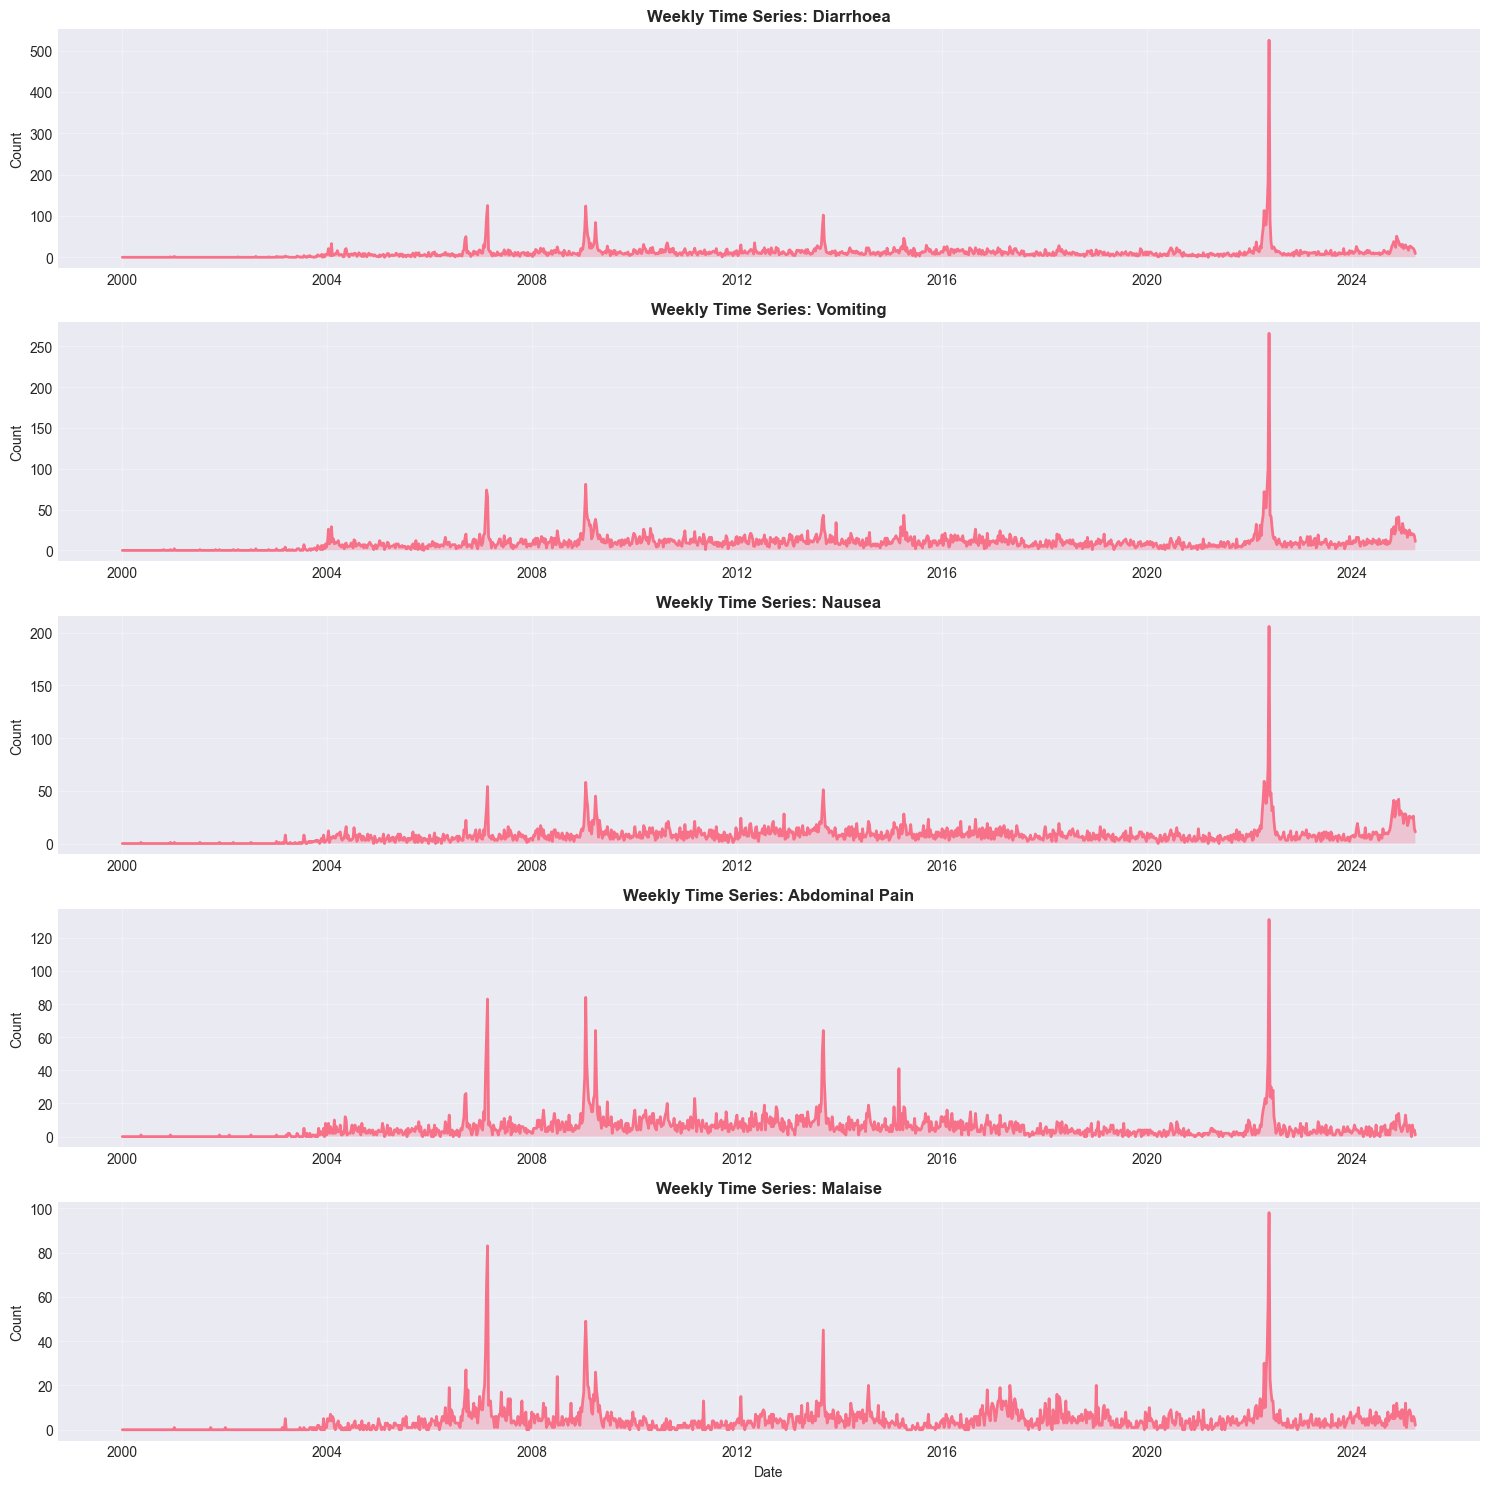

In [14]:
# Visualize time series for top 5 reactions
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

for idx, reaction in enumerate(top_reactions[:5]):
    axes[idx].plot(ts_weekly.index, ts_weekly[reaction], linewidth=2)
    axes[idx].set_title(f'Weekly Time Series: {reaction.title()}', fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].fill_between(ts_weekly.index, ts_weekly[reaction], alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

## 5. Statistical Features for Time Series

Calculate rolling statistics that will be useful for anomaly detection.

In [15]:
def add_rolling_features(ts_df, window=7):
    """
    Add rolling statistical features to time series
    
    Args:
        ts_df: Time series dataframe
        window: Rolling window size
    
    Returns:
        DataFrame with additional feature columns
    """
    result = ts_df.copy()
    
    for col in ts_df.columns:
        # Rolling mean
        result[f'{col}_rolling_mean'] = ts_df[col].rolling(window=window, min_periods=1).mean()
        
        # Rolling std
        result[f'{col}_rolling_std'] = ts_df[col].rolling(window=window, min_periods=1).std()
        
        # Z-score (standardized value)
        mean = result[f'{col}_rolling_mean']
        std = result[f'{col}_rolling_std']
        result[f'{col}_zscore'] = (ts_df[col] - mean) / (std + 1e-10)  # Add small value to avoid division by zero
    
    return result

# Add features to daily time series
print("Adding rolling features to daily time series...")
ts_daily_featured = add_rolling_features(ts_daily, window=7)
print(f"Original columns: {len(ts_daily.columns)}")
print(f"With features: {len(ts_daily_featured.columns)}")

Adding rolling features to daily time series...
Original columns: 20
With features: 80


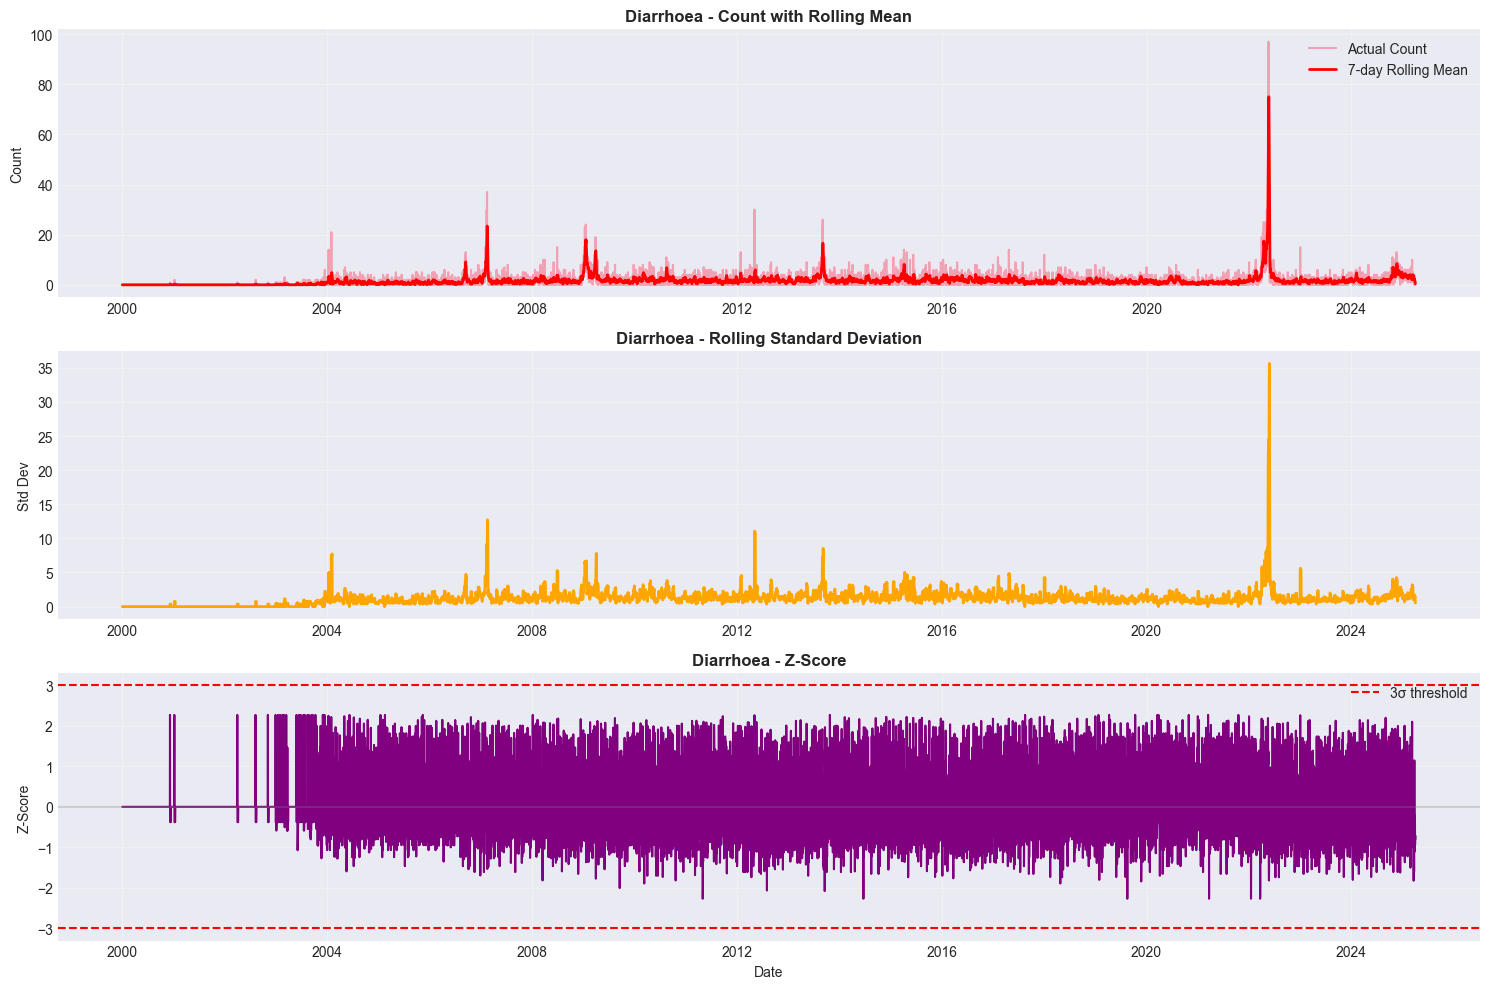

In [16]:
# Visualize rolling statistics for one reaction
reaction_example = top_reactions[0]

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original count
axes[0].plot(ts_daily.index, ts_daily[reaction_example], label='Actual Count', alpha=0.6)
axes[0].plot(ts_daily_featured.index, ts_daily_featured[f'{reaction_example}_rolling_mean'], 
            label='7-day Rolling Mean', linewidth=2, color='red')
axes[0].set_title(f'{reaction_example.title()} - Count with Rolling Mean', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling standard deviation
axes[1].plot(ts_daily_featured.index, ts_daily_featured[f'{reaction_example}_rolling_std'], 
            color='orange', linewidth=2)
axes[1].set_title(f'{reaction_example.title()} - Rolling Standard Deviation', fontweight='bold')
axes[1].set_ylabel('Std Dev')
axes[1].grid(True, alpha=0.3)

# Z-score
axes[2].plot(ts_daily_featured.index, ts_daily_featured[f'{reaction_example}_zscore'], 
            color='purple', linewidth=1.5)
axes[2].axhline(y=3, color='red', linestyle='--', label='3σ threshold')
axes[2].axhline(y=-3, color='red', linestyle='--')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[2].set_title(f'{reaction_example.title()} - Z-Score', fontweight='bold')
axes[2].set_ylabel('Z-Score')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Train/Test Split

For time series, we use temporal splits to avoid data leakage.

In [17]:
# Split by date - use last 20% for testing
split_date = ts_daily.index[int(len(ts_daily) * 0.8)]

# Daily splits
ts_daily_train = ts_daily[ts_daily.index < split_date]
ts_daily_test = ts_daily[ts_daily.index >= split_date]

# Weekly splits
split_date_weekly = ts_weekly.index[int(len(ts_weekly) * 0.8)]
ts_weekly_train = ts_weekly[ts_weekly.index < split_date_weekly]
ts_weekly_test = ts_weekly[ts_weekly.index >= split_date_weekly]

print("Daily time series split:")
print(f"  Train: {ts_daily_train.index.min()} to {ts_daily_train.index.max()} ({len(ts_daily_train)} records)")
print(f"  Test:  {ts_daily_test.index.min()} to {ts_daily_test.index.max()} ({len(ts_daily_test)} records)")

print("\nWeekly time series split:")
print(f"  Train: {ts_weekly_train.index.min()} to {ts_weekly_train.index.max()} ({len(ts_weekly_train)} records)")
print(f"  Test:  {ts_weekly_test.index.min()} to {ts_weekly_test.index.max()} ({len(ts_weekly_test)} records)")

Daily time series split:
  Train: 2000-01-01 00:00:00 to 2020-03-13 00:00:00 (7378 records)
  Test:  2020-03-14 00:00:00 to 2025-04-01 00:00:00 (1845 records)

Weekly time series split:
  Train: 2000-01-02 00:00:00 to 2020-03-08 00:00:00 (1054 records)
  Test:  2020-03-15 00:00:00 to 2025-03-30 00:00:00 (264 records)


## 7. Save Preprocessed Data

In [18]:
import os

# Create processed data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save cleaned raw data
df.to_parquet('../data/processed/cleaned_data.parquet', compression='snappy', index=False)
print("Saved: cleaned_data.parquet")

# Save time series data
ts_daily.to_parquet('../data/processed/timeseries_daily.parquet')
print("Saved: timeseries_daily.parquet")

ts_weekly.to_parquet('../data/processed/timeseries_weekly.parquet')
print("Saved: timeseries_weekly.parquet")

# Save train/test splits
ts_daily_train.to_parquet('../data/processed/timeseries_daily_train.parquet')
ts_daily_test.to_parquet('../data/processed/timeseries_daily_test.parquet')
print("Saved: daily train/test splits")

ts_weekly_train.to_parquet('../data/processed/timeseries_weekly_train.parquet')
ts_weekly_test.to_parquet('../data/processed/timeseries_weekly_test.parquet')
print("Saved: weekly train/test splits")

# Save list of top reactions for reference
import json
with open('../data/processed/top_reactions.json', 'w') as f:
    json.dump(top_reactions, f, indent=2)
print("Saved: top_reactions.json")

print("\n✓ All preprocessed data saved successfully!")

Saved: cleaned_data.parquet
Saved: timeseries_daily.parquet
Saved: timeseries_weekly.parquet
Saved: daily train/test splits
Saved: weekly train/test splits
Saved: top_reactions.json

✓ All preprocessed data saved successfully!


## 8. Summary Statistics

In [19]:
print("=" * 80)
print("PREPROCESSING SUMMARY")
print("=" * 80)
print(f"\nCleaned Dataset:")
print(f"  Total records: {len(df):,}")
print(f"  Date range: {df['date_started'].min()} to {df['date_started'].max()}")
print(f"  Unique reactions: {len(reaction_counts):,}")
print(f"  Focus reactions: {len(top_reactions)}")

print(f"\nTime Series Data:")
print(f"  Daily time series: {ts_daily.shape}")
print(f"  Weekly time series: {ts_weekly.shape}")
print(f"  Daily train/test: {ts_daily_train.shape} / {ts_daily_test.shape}")
print(f"  Weekly train/test: {ts_weekly_train.shape} / {ts_weekly_test.shape}")

print(f"\nNext Steps:")
print("  1. Implement baseline anomaly detection (Z-score, moving average)")
print("  2. Train Isolation Forest models")
print("  3. Implement ARIMA/Prophet models")
print("  4. Compare model performance")
print("  5. Validate against known FDA recalls")
print("\n" + "=" * 80)

PREPROCESSING SUMMARY

Cleaned Dataset:
  Total records: 57,188
  Date range: 2000-01-01 00:00:00 to 2025-04-01 00:00:00
  Unique reactions: 4,050
  Focus reactions: 20

Time Series Data:
  Daily time series: (9223, 20)
  Weekly time series: (1318, 20)
  Daily train/test: (7378, 20) / (1845, 20)
  Weekly train/test: (1054, 20) / (264, 20)

Next Steps:
  1. Implement baseline anomaly detection (Z-score, moving average)
  2. Train Isolation Forest models
  3. Implement ARIMA/Prophet models
  4. Compare model performance
  5. Validate against known FDA recalls

